In [1]:
# nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import multiprocessing
import time
import warnings

from tqdm import tqdm
from torch import nn
from torch_scatter import scatter
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCNConv, global_mean_pool
from torch_geometric.utils import add_self_loops, degree
from utils.preprocessing_for_tri_mesh import create_data

In [3]:
# load image file paths
svg_folder = './datasets/svg'
png_folder = './datasets/png'
imgs = []
png = []
dataset = []

for root, folders, files in os.walk(svg_folder):
    for file in files:
        if file.split('.')[1] != 'svg': continue
        if 'checkpoint' in file: continue
        
        file_path = os.path.join(svg_folder, file)
        imgs.append(file_path)
        
        file_path = os.path.join(png_folder, file.replace('svg', 'png'))
        png.append(file_path)

In [4]:
# warnings.filterwarnings("ignore")
# for i, file_path in enumerate(tqdm(imgs)):
#     try:
#         dataset.append(create_data(file_path))
#     except:
#         print(file_path)
#         raise SystemExit
        
#     # file_path = "./datasets/svg/032-firewood.svg"
#     # data = create_data(file_path)
#     # print(data)
#     # break

  3%|▎         | 355/10873 [00:59<29:10,  6.01it/s]  

./datasets/svg/cherry-230123-1.svg


AssertionError: 

In [5]:
# imgs = imgs[:2000]
# warnings.filterwarnings("ignore")
# dataset = []
# for data in tqdm(multiprocessing.Pool(8).imap_unordered(create_data, imgs), total=len(imgs)):
#     dataset.append(data)

 17%|█▋        | 348/2000 [01:11<05:40,  4.85it/s]


QhullError: QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate 0.06798

While executing:  | qhull d Qc Qbb Q12 Qz Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2097830057  delaunay  Qcoplanar-keep  Qbbound-last  Q12-allow-wide
  Qz-infinity-point  Qtriangulate  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 4.1e-05  Error-roundoff 1.7e-16  _one-merge 1.2e-15
  Visible-distance 3.4e-16  U-max-coplanar 3.4e-16  Width-outside 6.8e-16
  _wide-facet 2.1e-15  _maxoutside 1.4e-15


In [17]:
# hyperparameters
torch.manual_seed(16)

batch_size = 1
num_features = 2
num_output = 3
num_epoch = 50

_train = int(len(dataset) * 0.9)
_val = _train + int(len(dataset) * 0.05)
_test = len(dataset) - _val

# create dataloader
train_set, val_set, test_set = dataset[:_train], dataset[_train:_val], dataset[_val:]
train_svg, val_svg, test_svg = imgs[:_train], imgs[_train:_val], imgs[_val:]
train_png, val_png, test_png = png[:_train], png[_train:_val], png[_val:]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Training Data: {len(train_set)}\nValidation Data: {len(val_set)}\nTesting Data: {len(test_set)}")

Training Data: 1800
Validation Data: 100
Testing Data: 100


In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(2, 16, improved=True)
        self.conv2 = GCNConv(16, 32, improved=True)
        self.conv3 = GCNConv(32, 64, improved=True)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 3)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        cluster = data.cluster.type(torch.long)
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = scatter(x, cluster, dim=0, reduce='mean')
               
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss(reduction='mean')

In [23]:
# training
train_losses = []
val_losses = []
best_loss = float('inf')
err = 0

for epoch in range(num_epoch):  # num_epoch
    train_loss = 0
    val_loss = 0
    
    model.train()
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device)
        if data.x.shape[0] == 0:
            err += 1
            continue
        
        optimizer.zero_grad()
        out = model(data)
        # h = data.h.type(torch.LongTensor).to(device)
        # loss = criterion(out, h)
        loss = criterion(out, data.rgb)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        out = model(data)
        
        # h = data.h.type(torch.LongTensor).to(device)
        # loss = criterion(out, h)
        loss = criterion(out, data.rgb)
        
        val_loss += loss.item()
    
    train_avg = train_loss / len(train_loader)
    val_avg = val_loss / len(val_loader)
    train_losses.append(loss.item())
    val_losses.append(loss.item())
    
    print(f'Epoch {epoch}\tTraining Loss: {train_avg}\tValidation Loss: {val_avg}')
    
    if val_avg < best_loss:
        print(f'Validation Loss Decreased({best_loss:.6f}--->{val_avg:.6f})\tSaving The Model')
        best_loss = val_avg
        torch.save(model.state_dict(), 'best_checkpoint.pth')

100%|██████████| 100/100 [00:02<00:00, 38.21it/s]


Epoch 0	Training Loss: 0.11584227419923991	Validation Loss: 0.11648394100368023
Validation Loss Decreased(inf--->0.116484)	Saving The Model


100%|██████████| 100/100 [00:02<00:00, 40.65it/s]


Epoch 1	Training Loss: 0.11321641823690798	Validation Loss: 0.11902804628014564


100%|██████████| 100/100 [00:02<00:00, 48.97it/s]


Epoch 2	Training Loss: 0.11306409084858994	Validation Loss: 0.11752324484288693


100%|██████████| 100/100 [00:02<00:00, 44.94it/s]


Epoch 3	Training Loss: 0.11328291511732257	Validation Loss: 0.11733816966414451


100%|██████████| 100/100 [00:02<00:00, 44.37it/s]


Epoch 4	Training Loss: 0.11322717810618795	Validation Loss: 0.11785755045711994


 77%|███████▋  | 1383/1800 [00:37<00:11, 37.02it/s]


KeyboardInterrupt: 

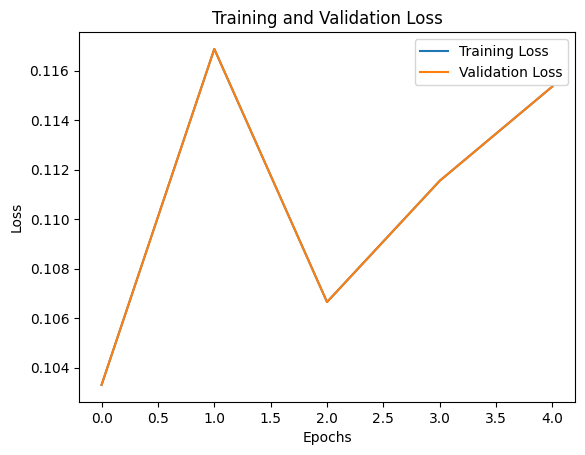

In [26]:
# plot losses
import matplotlib.pyplot as plt

_x = list(range(num_epoch))  # num_epoch
plt.plot(_x, train_losses, label='Training Loss')
plt.plot(_x, val_losses, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# testing
model.load_state_dict(torch.load('./best_checkpoint.pth'))
model.eval()

test_loss = 0
for i, data in enumerate(tqdm(test_loader)):
    data = data.to(device)
    out = model(data)
    loss = criterion(out, data.rgb)
    test_loss += loss.item()
    
print(f'Testing Loss: {test_loss / len(test_loader)}')

100%|██████████| 100/100 [00:02<00:00, 44.69it/s]

Testing Loss: 0.11125892922282218


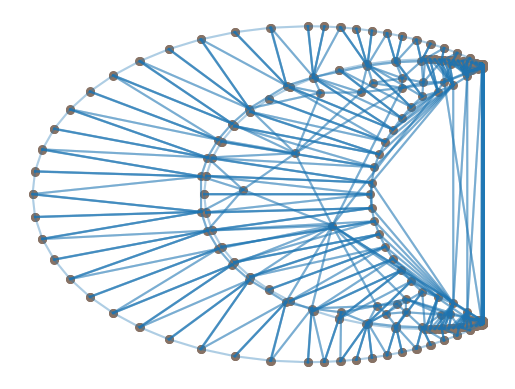

In [40]:
# visualize testing results
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

vis_loader = DataLoader(test_set, batch_size=1, shuffle=False)
model.load_state_dict(torch.load('./best_checkpoint.pth'))
model.eval()

fig = plt.figure("plot")
ax = fig.add_subplot(1, 1, 1)
plt.axis("off")

for data, png in zip(vis_loader, test_png):
    data = data.to(device)
    out = model(data)
    
    pos = data.x.cpu().detach().numpy()
    rgb = out.cpu().detach().numpy()
    edge = np.transpose(data.edge_index.cpu().detach().numpy())
    cluster = data.cluster.cpu().detach().numpy()

    for n1, n2 in edge:
        x1, y1 = pos[n1]
        x2, y2 = pos[n2]
        l = Line2D([x1,x2], [y1,y2], alpha=0.2)
        ax.add_line(l)
    
    for (x, y), clu in zip(pos, cluster):
        plt.scatter(x, y, color=rgb[int(clu)], s=30)
        
    plt.axis("off")
    plt.show()
    plt.close()
    break